In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gycamodel2/GygaModelRunsUganda.xlsx


In [2]:
input_path = "/kaggle/input/"
files = os.listdir(input_path)
print("Files in /kaggle/input/:", files)
# Define dataset directory path
dataset_path = "/kaggle/input/gycamodel2"

# List all files in the directory
files = os.listdir(dataset_path)
print("Files in gycamodel2:", files)

# Define the correct file path
file_path = "/kaggle/input/gycamodel2/GygaModelRunsUganda.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    df.to_csv(f"{sheet_name}.csv", index=False)
    print(f"Saved {sheet_name}.csv")
# List all files in the specified directory
file_path = "Station.csv"  # Adjust the file path as necessary
df = pd.read_csv(file_path)
print("First few rows of the data:")
print(df.head())

Files in /kaggle/input/: ['gycamodel2']
Files in gycamodel2: ['GygaModelRunsUganda.xlsx']


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Saved Info.csv
Saved Station.csv
Saved Station Year.csv
Saved Rainfed maize model runs.csv
Saved Rainfed rice model runs.csv
Saved Rainfed sorghum model runs.csv
Saved Rainfed millet model runs.csv
First few rows of the data:
  STATIONNAME  LONGITUDE  LATITUDE  ELEVATION_METER COUNTRY           CROP  \
0        Arua  30.916667  3.050000             1211  Uganda  Rainfed maize   
1     Bulindi  31.440560  1.476390             1209  Uganda  Rainfed maize   
2        Gulu  32.283333  2.783333             1105  Uganda  Rainfed maize   
3      Kabale  30.010000 -1.236000             1869  Uganda  Rainfed maize   
4      Kitgum  32.886700  3.278300              953  Uganda  Rainfed maize   

     YA         YW      YW-YA       YP    YP-YA        WPP       WPA  \
0  1.20   7.992575   6.792575  14.0400  12.8400  16.244501  2.438939   
1  1.65   5.656925   4.006925  10.6350   8.9850  12.186017  3.554392   
2  1.15  12.879035  11.729035  15.6700  14.5200  22.250772  1.986825   
3  1.15   3.49825

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [4]:

# Define Teacher Models
class TeacherModel1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TeacherModel1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class TeacherModel2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TeacherModel2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class TeacherModel3(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TeacherModel3, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Define Student Model
class StudentModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load dataset (with basic preprocessing)

def load_dataset(file_path, target_column='YA'):  # Added target_column parameter
    df = pd.read_csv(file_path)
    df = df.dropna()

    # Separate features and target
    y = df[target_column].values.astype(np.float32)  # Target is YA
    X = df.drop(target_column, axis=1)  # Features are all other columns

    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    if categorical_cols:
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le

    scaler = MinMaxScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    X = X.values.astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)

# Train teacher models
def train_teacher(model, X_train, y_train, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_data = torch.utils.data.TensorDataset(X_train, y_train.view(-1, 1))  # Reshape y
    dataloader = DataLoader(train_data, batch_size=4, shuffle=True, drop_last=False)

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
# Train student model using teacher predictions
def train_student(student_model, teacher_models, X_train, y_train, epochs=100, lr=0.01):
    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_data = torch.utils.data.TensorDataset(X_train, y_train.view(-1, 1))  # Reshape y
    dataloader = DataLoader(train_data, batch_size=4, shuffle=True, drop_last=False)

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            teacher_preds = [teacher(batch_X).detach() for teacher in teacher_models]
            avg_teacher_preds = torch.mean(torch.stack(teacher_preds), dim=0)
            student_preds = student_model(batch_X)
            loss = criterion(student_preds, avg_teacher_preds)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Student Loss: {loss.item():.4f}")

# Evaluate student model (RMSE and R²)
def evaluate_student(student_model, X_test, y_test):
    student_model.eval()
    with torch.no_grad():
        student_preds = student_model(X_test)
        mse = mean_squared_error(y_test.numpy(), student_preds.numpy())
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test.numpy(), student_preds.numpy())
        accuracy = max(0, 100 - (mse * 100))
        print(f"RMSE: {rmse:.4f}")
        print(f"R-squared: {r2:.4f}")
        print(f"Test Loss (MSE): {mse:.4f}")
        print(f"Accuracy: {accuracy:.2f}%")
# Example Usage
file_path = "Station.csv"
X_train, X_test, y_train, y_test = load_dataset(file_path)
input_dim = X_train.shape[1]
output_dim = 1  # Predict a single value (YA)

# Initialize and train teachers
teacher1 = TeacherModel1(input_dim, output_dim)
teacher2 = TeacherModel2(input_dim, output_dim)
teacher3 = TeacherModel3(input_dim, output_dim)
print("Training Teacher Models...")
print("Training Teacher Models...")
train_teacher(teacher1, X_train, y_train)  # Pass X_train and y_train
train_teacher(teacher2, X_train, y_train)  # Pass X_train and y_train
train_teacher(teacher3, X_train, y_train)  # Pass X_train and y_train
# Train student model using teacher predictions

student = StudentModel(input_dim, output_dim)
print("Training Student Model...")
train_student(student, [teacher1, teacher2, teacher3], X_train, y_train) # Pass X_train and y_train

# Evaluate Student Model
print("Evaluating Student Model...")
evaluate_student(student, X_test, y_test) # Pass X_test and y_test

Training Teacher Models...
Training Teacher Models...
Epoch 10, Loss: 0.0083
Epoch 20, Loss: 0.0003
Epoch 30, Loss: 0.0001
Epoch 40, Loss: 0.0003
Epoch 50, Loss: 0.0000
Epoch 60, Loss: 0.0029
Epoch 70, Loss: 0.0003
Epoch 80, Loss: 0.0037
Epoch 90, Loss: 0.0369
Epoch 100, Loss: 0.0010
Epoch 10, Loss: 0.0083
Epoch 20, Loss: 0.0046
Epoch 30, Loss: 0.0027
Epoch 40, Loss: 0.0011
Epoch 50, Loss: 0.0001
Epoch 60, Loss: 0.0003
Epoch 70, Loss: 0.0001
Epoch 80, Loss: 0.0021
Epoch 90, Loss: 0.0002
Epoch 100, Loss: 0.0004
Epoch 10, Loss: 0.1464
Epoch 20, Loss: 0.0057
Epoch 30, Loss: 0.0024
Epoch 40, Loss: 0.0020
Epoch 50, Loss: 0.0019
Epoch 60, Loss: 0.0010
Epoch 70, Loss: 0.0003
Epoch 80, Loss: 0.0020
Epoch 90, Loss: 0.0008
Epoch 100, Loss: 0.0000
Training Student Model...
Epoch 10, Student Loss: 0.0135
Epoch 20, Student Loss: 0.0001
Epoch 30, Student Loss: 0.0003
Epoch 40, Student Loss: 0.0001
Epoch 50, Student Loss: 0.0000
Epoch 60, Student Loss: 0.0000
Epoch 70, Student Loss: 0.0000
Epoch 80, 

In [5]:
pip install torch pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

def get_ya_column_index(file_path):
    """
    Loads a CSV file and returns the index of the 'YA' column.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        int: The index of the 'YA' column, or -1 if not found.
    """
    try:
        df = pd.read_csv(file_path)
        column_names = df.columns.tolist()
        ya_index = column_names.index('YA')
        return ya_index
    except ValueError:
        # 'YA' column not found
        return -1
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return -1

# Example usage
file_path = "Station.csv"  # Replace with your file path
ya_index = get_ya_column_index(file_path)

if ya_index != -1:
    print(f"The index of the 'YA' column is: {ya_index}")
else:
    print("The 'YA' column was not found in the DataFrame.")

The index of the 'YA' column is: 6


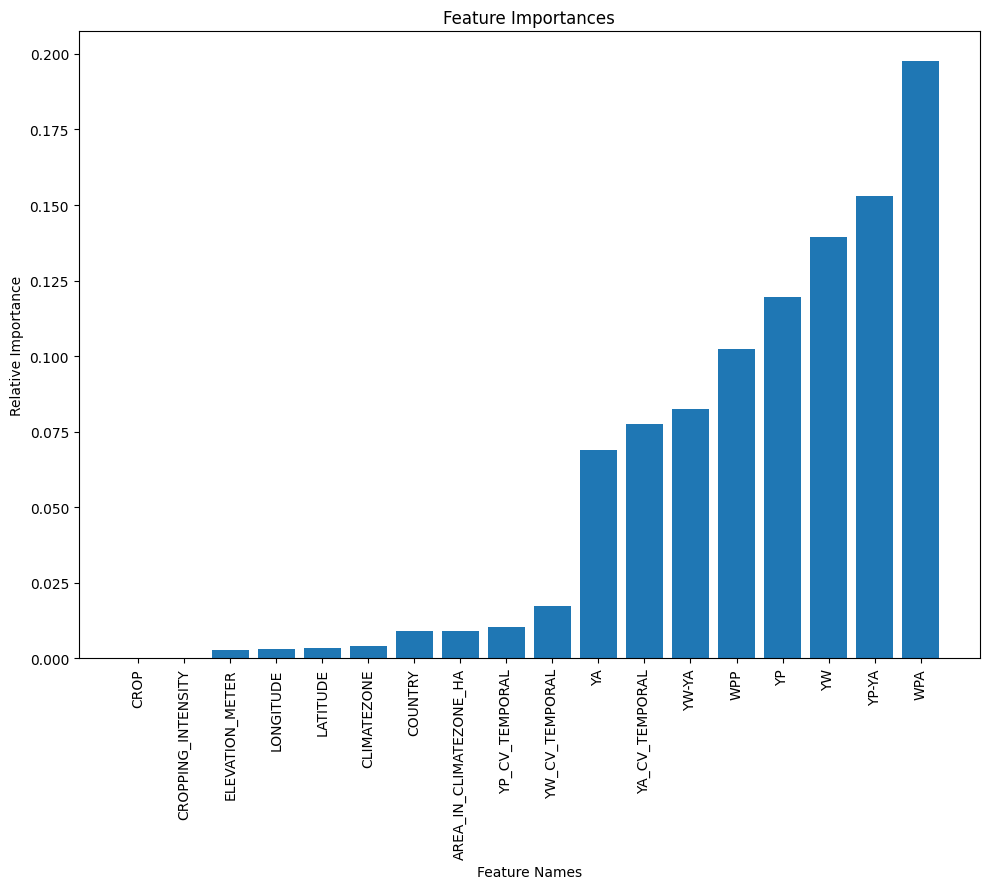

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
def load_dataset_for_rf(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna()

    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if categorical_cols:
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    X = df.drop(columns=numeric_cols[6]).values 
    y = df[numeric_cols[6]].values

    return X, y, df.columns.tolist()

# Feature Importance using Random Forest
def feature_importance_rf(X, y, feature_names):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, len(feature_names) / 2))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center') # change to bar, for vertical bars.
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90) #change to xticks and rotate.
    plt.ylabel('Relative Importance') #swap x and y labels.
    plt.xlabel('Feature Names')
    plt.tight_layout() #avoid labels being cut off.
    plt.show()
file_path = "Station.csv"
X, y, feature_names = load_dataset_for_rf(file_path) #Use the correct function here.

# Remove the target variable from feature names
feature_names.remove(feature_names[0])

feature_importance_rf(X, y, feature_names)


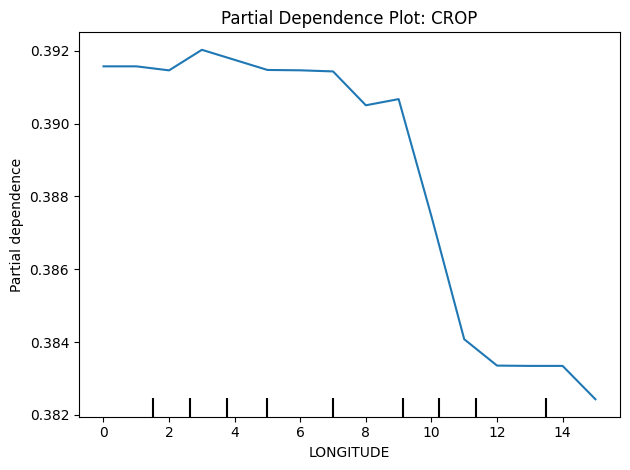

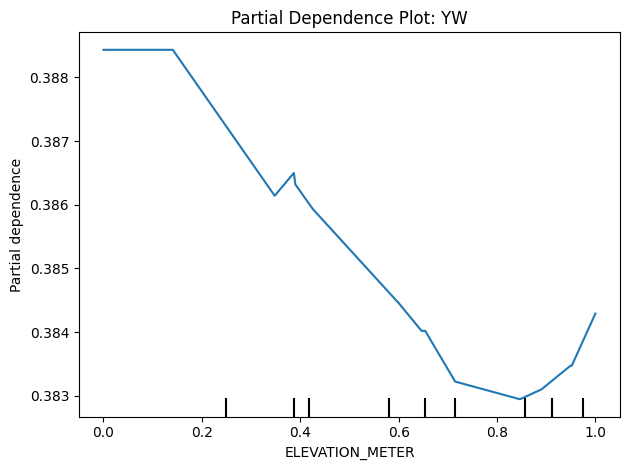

In [8]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

def train_random_forest(X, y):
    """Trains a Random Forest Regressor."""
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    return rf

def plot_partial_dependence(rf_model, X, feature_names, feature_index, feature_name):
    
    try:
        PartialDependenceDisplay.from_estimator(rf_model, X, [feature_index], feature_names=feature_names)
        plt.title(f'Partial Dependence Plot: {feature_name}')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting PDP: {e}")

# Example usage:
file_path = "Station.csv"  # Replace with your file path
try:
    X, y, feature_names = load_dataset_for_rf(file_path)
    rf_model = train_random_forest(X, y)

    # Example: Plot PDP for the first feature (index 0)
    feature_index = 0
    feature_name = feature_names[feature_index + 5] #+1 because the target was dropped.
    plot_partial_dependence(rf_model, X, feature_names[1:], feature_index, feature_name) #feature_names[1:] to exclude the target.

    # Example: Plot PDP for another feature (e.g., the third feature)
    feature_index = 2
    feature_name = feature_names[7] #+1 because the target was dropped.
    plot_partial_dependence(rf_model, X, feature_names[1:], feature_index, feature_name)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")


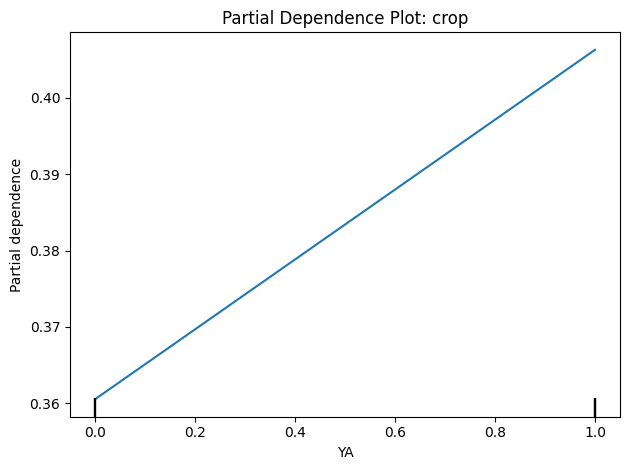

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay


def plot_partial_dependence(rf_model, X, feature_names, feature_index, feature_name):
    
    try:
        PartialDependenceDisplay.from_estimator(rf_model, X, [feature_index], feature_names=feature_names)
        plt.title(f'Partial Dependence Plot: {feature_name}')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting PDP: {e}")

# Example usage:
file_path = "Station.csv"  # Replace with your file path
try:
    X, y, feature_names = load_dataset_for_rf(file_path)
    rf_model = train_random_forest(X, y)

    # Find the index of the 'crop' feature.
    if 'YA' in feature_names:
        crop_index = feature_names.index('YA') -1 # -1 to account for the target being dropped.
        plot_partial_dependence(rf_model, X, feature_names[1:], crop_index, 'crop')
    else:
        print("The 'crop' feature was not found in the dataset.")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

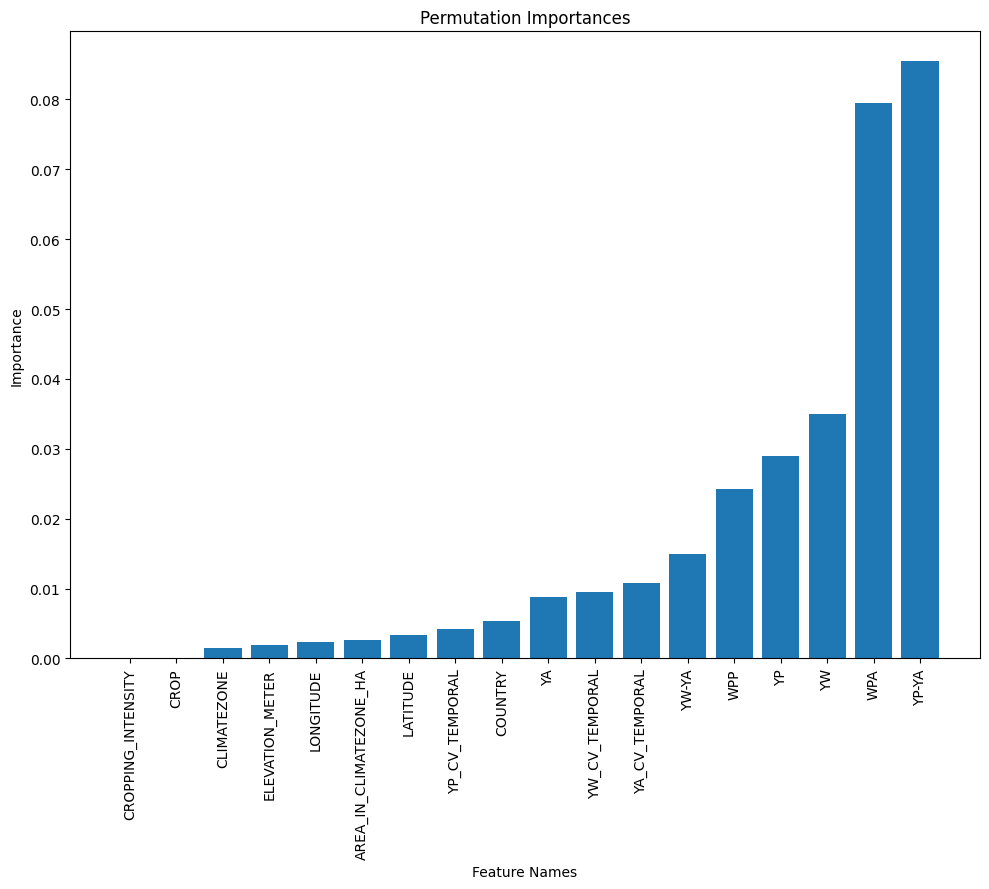

In [10]:
from sklearn.inspection import permutation_importance
def plot_permutation_importance(rf_model, X, y, feature_names):
    
    try:
        result = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)
        importances = result.importances_mean
        indices = np.argsort(importances)

        plt.figure(figsize=(10, len(feature_names) / 2))
        plt.title('Permutation Importances')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.ylabel('Importance')
        plt.xlabel('Feature Names')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while calculating/plotting Permutation Importance: {e}")

# Example usage:
file_path = "Station.csv"  # Replace with your file path
try:
    X, y, feature_names = load_dataset_for_rf(file_path)
    rf_model = train_random_forest(X, y)

    # Remove the target variable from feature names
    feature_names.remove(feature_names[0])

    plot_permutation_importance(rf_model, X, y, feature_names)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

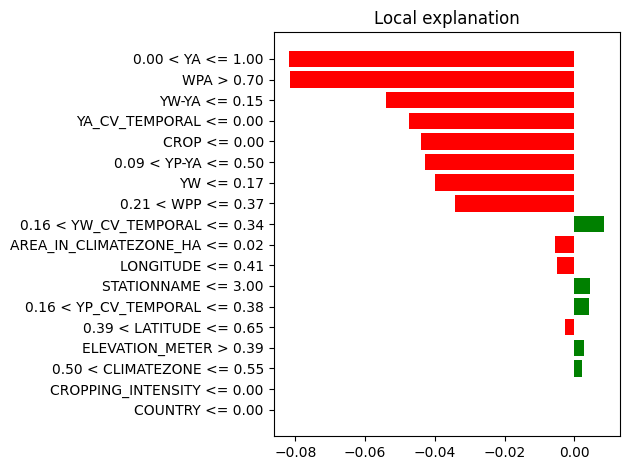

In [11]:
import lime.lime_tabular
def load_dataset_for_rf(file_path):
    """Loads and preprocesses the dataset."""
    df = pd.read_csv(file_path)
    df = df.dropna()

    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if categorical_cols:
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    X = df.drop(columns=numeric_cols[6]).values
    y = df[numeric_cols[6]].values
    feature_names = df.drop(columns=numeric_cols[6]).columns.tolist()

    return X, y, feature_names, df

def train_random_forest(X, y):
    """Trains a Random Forest Regressor."""
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    return rf
def explain_prediction_lime(rf_model, X, feature_names, df, prediction_index):
    """
    Provides local interpretable explanations for a prediction using LIME.

    Args:
        rf_model: Trained Random Forest model.
        X: Feature matrix.
        feature_names: List of feature names.
        df: the original dataframe, to use for lime.
        prediction_index: Index of the prediction to explain.
    """
    try:
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X, feature_names=feature_names, mode='regression', random_state=42
        )
        explanation = explainer.explain_instance(X[prediction_index], rf_model.predict, num_features=len(feature_names))
        explanation.show_in_notebook(show_table=True, show_all=False)

        # Optionally, plot the explanation
        explanation.as_pyplot_figure()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while explaining prediction with LIME: {e}")

# Example usage:
file_path = "Station.csv"  # Replace with your file path
try:
    X, y, feature_names, df = load_dataset_for_rf(file_path)
    rf_model = train_random_forest(X, y)

    # Explain a specific prediction (e.g., the first prediction)
    prediction_index = 0
    explain_prediction_lime(rf_model, X, feature_names, df, prediction_index)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

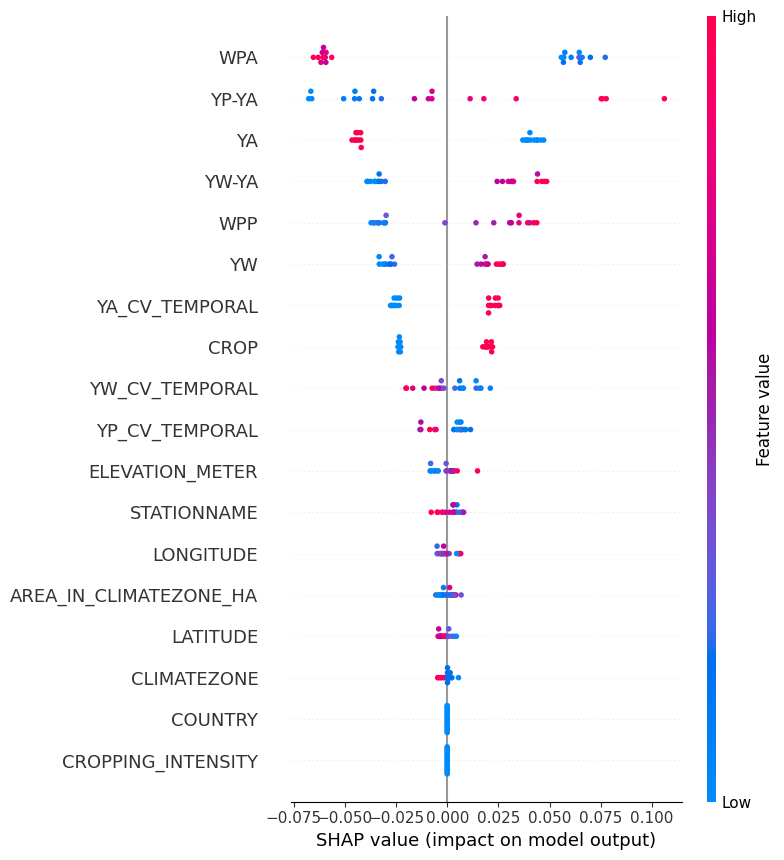

<Figure size 640x480 with 0 Axes>

In [12]:
import shap
def explain_prediction_shap(rf_model, X, feature_names):
    
    try:
        explainer = shap.TreeExplainer(rf_model)  # TreeExplainer for Random Forest
        shap_values = explainer.shap_values(X)

        # Summary plot (feature importance)
        shap.summary_plot(shap_values, X, feature_names=feature_names)
        plt.tight_layout()
        plt.show()

        # Optionally, force plot for a specific prediction (e.g., the first)
        shap.initjs()
        shap.force_plot(explainer.expected_value, shap_values[0], X[0], feature_names=feature_names)

    except Exception as e:
        print(f"An error occurred while explaining prediction with SHAP: {e}")

# Example usage:
file_path = "Station.csv"  # Replace with your file path
try:
    X, y, feature_names, df = load_dataset_for_rf(file_path)
    rf_model = train_random_forest(X, y)

    explain_prediction_shap(rf_model, X, feature_names)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")